## **1. Setting**

In [1]:
# drive.mount
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Input, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold

import warnings
warnings.filterwarnings('ignore')

## **2. Read Data & Encoding & Split**

In [ ]:
# import data
PATH = "dir/"

train = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")
submission = pd.read_csv(PATH + "sample_submission.csv")

# data shape
train.shape, test.shape, submission.shape

((4984331, 65), (1000000, 64), (1000000, 2))

In [ ]:
# LabelEncoding
encoder = LabelEncoder()
target = 'Cover_Type'

train[target] = encoder.fit_transform(train[target])

y = train[target].values
X = train.drop(target, axis=1)
Xt = test

## **3. Reduce Data Size**

In [ ]:
def reduce_mem_usage(df, verbose = True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 622.70 Mb (74.8% reduction)
Mem. usage decreased to 123.98 Mb (74.6% reduction)


## **4. Fuction Setting (Model, Visualization)**

In [ ]:
# https://www.kaggle.com/lucamassaron/tfkeras-dnn-with-multiclass-focal-loss
# Model
def get_model(layers = [8], targets = 7, dropout_rate = 0.0, skip_layers = True, 
              batchnorm = True, activation = 'selu', kernel_initializer = "lecun_normal"):
    
    inputs_sequence = Input(shape = (X.shape[1]))
    x = Flatten()(inputs_sequence)

    # layer parameter의 길이만큼 layer를 쌓아올림
    skips = list()
    for layer, nodes in enumerate(layers):

        # batchnorm과 dropout은 parameter 값에따라 유동적으로 조정
        x = Dense(nodes,
                  kernel_initializer = kernel_initializer,
                  activation = activation)(x)

        if batchnorm is True:
            x = BatchNormalization()(x)

        if layer != (len(layers) - 1):
            if dropout_rate > 0:
                x = Dropout(rate = dropout_rate)(x)
            skips.append(x)
    
    # 위의 반복문에서 각 반복의 끝 레이어를 skip layer로 설정
    if skip_layers is True:
        x = Concatenate(axis = 1)([x] + skips)
    else:
        del(skips)
      
    # Multi class classification을 위한 마지막 레이어 별도 설정
    output_class = Dense(targets, activation='softmax', 
                         kernel_regularizer=tf.keras.regularizers.l2(l2 = 0.0001))(x)

    model = Model(inputs = inputs_sequence, outputs = output_class)
    
    return model

In [ ]:
# Visualization
def plot_keras_history(history, measures):
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize = (15, 5))
    plt.subplots_adjust(top = 0.99, bottom = 0.01, hspace = 0.4, wspace = 0.2)
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label = "Train " + measure)
        panel.plot(history.epoch, history.history["val_" + measure], label = "Validation " + measure)
        panel.set(xlabel = 'epochs', ylabel = measure)
        panel.legend()
        
    plt.show(fig)

## **5. Model Setting, Complie**

In [ ]:
# parameter setting
early_stopping = EarlyStopping(
    monitor = 'val_acc', 
    min_delta = 0, 
    patience = 10, 
    verbose = 0,
    mode = 'max', 
    baseline = None, 
    restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_acc', 
    factor = 0.5,
    patience = 5,
    mode = 'max')

In [ ]:
# model setting
dnn_params = {'layers': [128, 64, 64, 64], 
              'batchnorm': True, 
              'skip_layers': True, 
              'targets': len(encoder.classes_)}

model = get_model(**dnn_params)

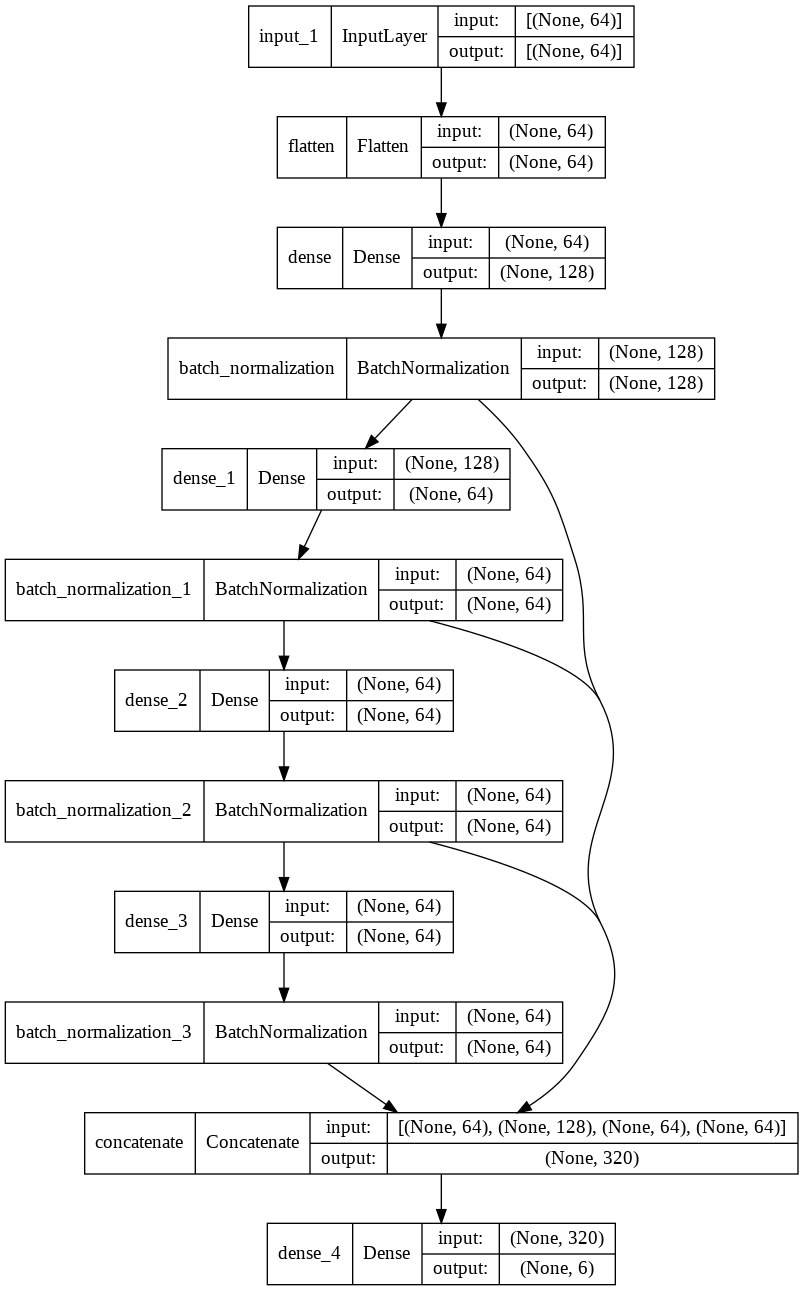

In [ ]:
# model setting visualization
plot_model(
    model, 
    to_file='baseline.png', 
    show_shapes=True,
    show_layer_names=True)

## **6. Model Train(K-fold Cross Validation)**

****************************************
Fold 1 || Training
****************************************
Epoch 1/150
2191/2191 [==============================] - 37s 14ms/step - loss: 0.2049 - acc: 0.9407 - val_loss: 0.1355 - val_acc: 0.9516 - lr: 0.0010
Epoch 2/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1236 - acc: 0.9548 - val_loss: 0.1144 - val_acc: 0.9562 - lr: 0.0010
Epoch 3/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1089 - acc: 0.9583 - val_loss: 0.1054 - val_acc: 0.9577 - lr: 0.0010
Epoch 4/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.1014 - acc: 0.9602 - val_loss: 0.1013 - val_acc: 0.9583 - lr: 0.0010
Epoch 5/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.0968 - acc: 0.9613 - val_loss: 0.1020 - val_acc: 0.9579 - lr: 0.0010
Epoch 6/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.0937 - acc: 0.9620 - val_loss: 0.0980 - val_acc: 0.9590 - lr: 0.0010

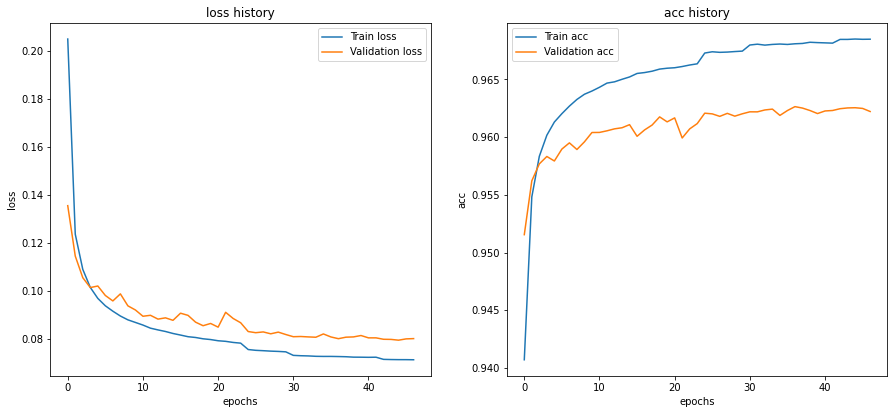

Best training accuracy: 0.96851
Best validation accuracy: 0.96265
****************************************
Fold 2 || Training
****************************************
Epoch 1/150
2191/2191 [==============================] - 38s 15ms/step - loss: 0.2030 - acc: 0.9413 - val_loss: 0.1305 - val_acc: 0.9533 - lr: 0.0010
Epoch 2/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1233 - acc: 0.9550 - val_loss: 0.1167 - val_acc: 0.9551 - lr: 0.0010
Epoch 3/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1083 - acc: 0.9586 - val_loss: 0.1051 - val_acc: 0.9579 - lr: 0.0010
Epoch 4/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1003 - acc: 0.9606 - val_loss: 0.1026 - val_acc: 0.9579 - lr: 0.0010
Epoch 5/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.0960 - acc: 0.9617 - val_loss: 0.0995 - val_acc: 0.9583 - lr: 0.0010
Epoch 6/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.09

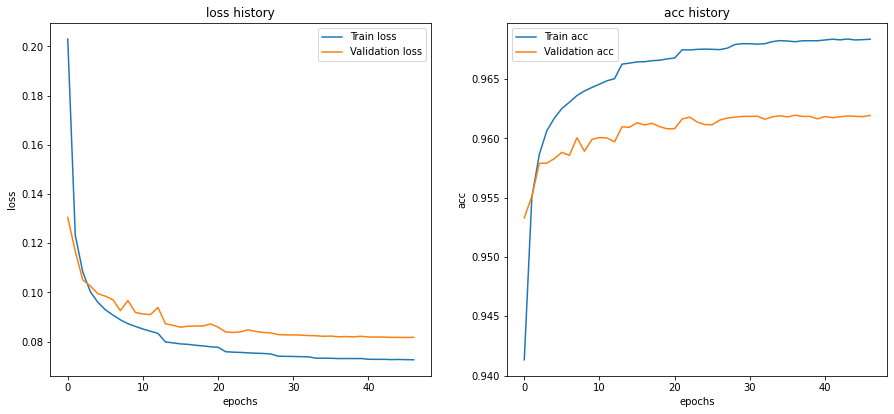

Best training accuracy: 0.96838
Best validation accuracy: 0.96195
****************************************
Fold 3 || Training
****************************************
Epoch 1/150
2191/2191 [==============================] - 37s 15ms/step - loss: 0.2073 - acc: 0.9400 - val_loss: 0.1276 - val_acc: 0.9548 - lr: 0.0010
Epoch 2/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1242 - acc: 0.9546 - val_loss: 0.1155 - val_acc: 0.9553 - lr: 0.0010
Epoch 3/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.1093 - acc: 0.9583 - val_loss: 0.1090 - val_acc: 0.9565 - lr: 0.0010
Epoch 4/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1014 - acc: 0.9603 - val_loss: 0.1108 - val_acc: 0.9552 - lr: 0.0010
Epoch 5/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.0969 - acc: 0.9614 - val_loss: 0.0981 - val_acc: 0.9591 - lr: 0.0010
Epoch 6/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.09

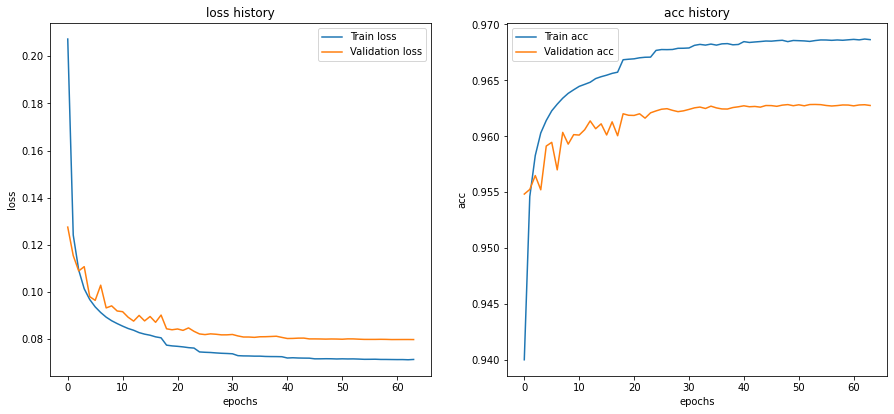

Best training accuracy: 0.96869
Best validation accuracy: 0.96285
****************************************
Fold 4 || Training
****************************************
Epoch 1/150
2191/2191 [==============================] - 38s 15ms/step - loss: 0.2040 - acc: 0.9410 - val_loss: 0.1310 - val_acc: 0.9529 - lr: 0.0010
Epoch 2/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.1225 - acc: 0.9550 - val_loss: 0.1200 - val_acc: 0.9539 - lr: 0.0010
Epoch 3/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.1079 - acc: 0.9587 - val_loss: 0.1035 - val_acc: 0.9586 - lr: 0.0010
Epoch 4/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1006 - acc: 0.9605 - val_loss: 0.1005 - val_acc: 0.9588 - lr: 0.0010
Epoch 5/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.0962 - acc: 0.9615 - val_loss: 0.0975 - val_acc: 0.9591 - lr: 0.0010
Epoch 6/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.09

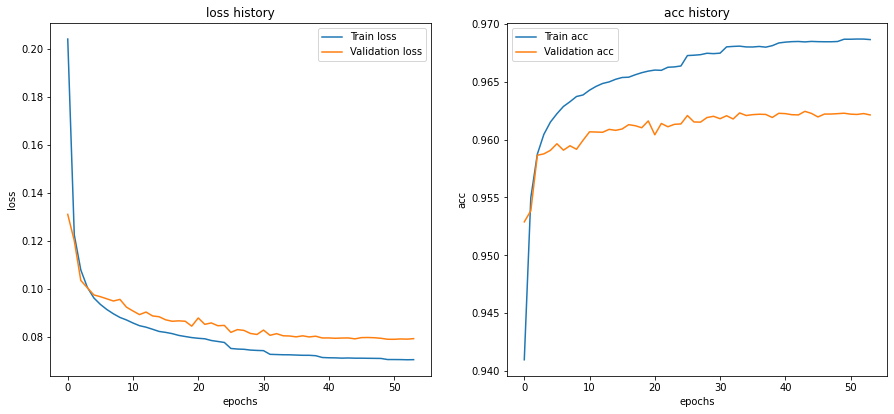

Best training accuracy: 0.96869
Best validation accuracy: 0.96244
****************************************
Fold 5 || Training
****************************************
Epoch 1/150
2191/2191 [==============================] - 37s 15ms/step - loss: 0.2052 - acc: 0.9402 - val_loss: 0.1340 - val_acc: 0.9528 - lr: 0.0010
Epoch 2/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1248 - acc: 0.9546 - val_loss: 0.1154 - val_acc: 0.9559 - lr: 0.0010
Epoch 3/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.1098 - acc: 0.9581 - val_loss: 0.1063 - val_acc: 0.9571 - lr: 0.0010
Epoch 4/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1020 - acc: 0.9600 - val_loss: 0.1047 - val_acc: 0.9570 - lr: 0.0010
Epoch 5/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.0976 - acc: 0.9611 - val_loss: 0.0994 - val_acc: 0.9589 - lr: 0.0010
Epoch 6/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.09

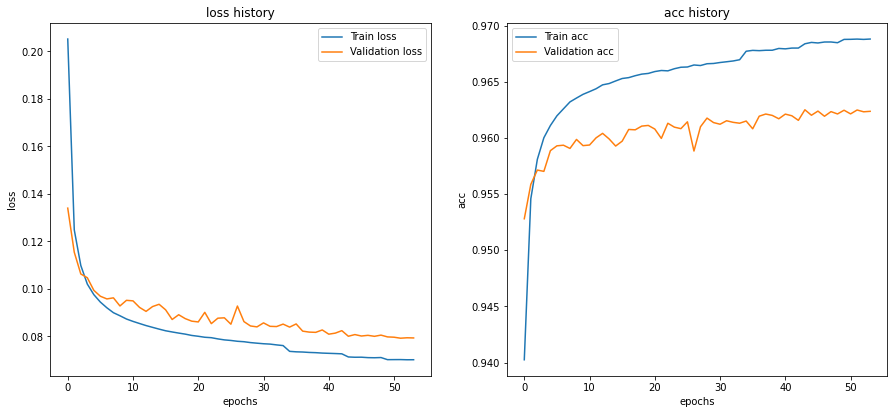

Best training accuracy: 0.96882
Best validation accuracy: 0.96252
****************************************
Fold 6 || Training
****************************************
Epoch 1/150
2191/2191 [==============================] - 37s 15ms/step - loss: 0.2074 - acc: 0.9403 - val_loss: 0.1372 - val_acc: 0.9508 - lr: 0.0010
Epoch 2/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.1242 - acc: 0.9547 - val_loss: 0.1160 - val_acc: 0.9554 - lr: 0.0010
Epoch 3/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1090 - acc: 0.9585 - val_loss: 0.1077 - val_acc: 0.9569 - lr: 0.0010
Epoch 4/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1016 - acc: 0.9601 - val_loss: 0.1032 - val_acc: 0.9581 - lr: 0.0010
Epoch 5/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.0971 - acc: 0.9614 - val_loss: 0.0981 - val_acc: 0.9591 - lr: 0.0010
Epoch 6/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.09

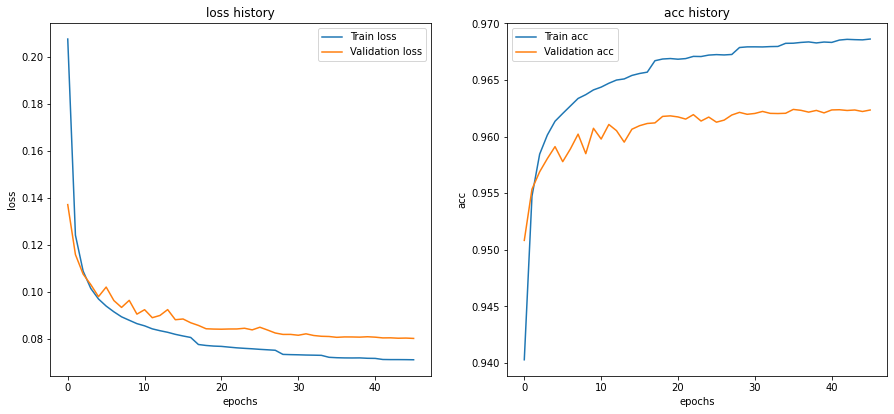

Best training accuracy: 0.96861
Best validation accuracy: 0.96240
****************************************
Fold 7 || Training
****************************************
Epoch 1/150
2191/2191 [==============================] - 37s 14ms/step - loss: 0.2001 - acc: 0.9415 - val_loss: 0.1344 - val_acc: 0.9518 - lr: 0.0010
Epoch 2/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1226 - acc: 0.9551 - val_loss: 0.1102 - val_acc: 0.9571 - lr: 0.0010
Epoch 3/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1085 - acc: 0.9584 - val_loss: 0.1079 - val_acc: 0.9566 - lr: 0.0010
Epoch 4/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1009 - acc: 0.9604 - val_loss: 0.1005 - val_acc: 0.9586 - lr: 0.0010
Epoch 5/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.0964 - acc: 0.9615 - val_loss: 0.1016 - val_acc: 0.9579 - lr: 0.0010
Epoch 6/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.09

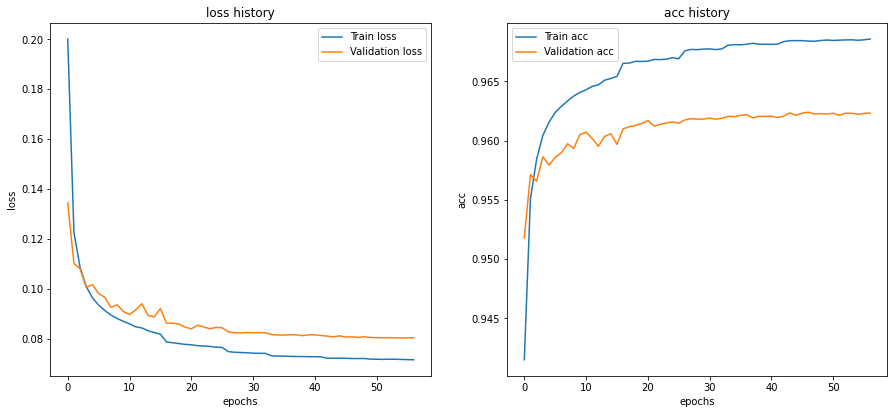

Best training accuracy: 0.96857
Best validation accuracy: 0.96239
****************************************
Fold 8 || Training
****************************************
Epoch 1/150
2191/2191 [==============================] - 38s 15ms/step - loss: 0.2019 - acc: 0.9412 - val_loss: 0.1312 - val_acc: 0.9532 - lr: 0.0010
Epoch 2/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1223 - acc: 0.9555 - val_loss: 0.1133 - val_acc: 0.9563 - lr: 0.0010
Epoch 3/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1080 - acc: 0.9589 - val_loss: 0.1089 - val_acc: 0.9568 - lr: 0.0010
Epoch 4/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.1010 - acc: 0.9604 - val_loss: 0.1055 - val_acc: 0.9571 - lr: 0.0010
Epoch 5/150
2191/2191 [==============================] - 30s 13ms/step - loss: 0.0968 - acc: 0.9614 - val_loss: 0.0994 - val_acc: 0.9583 - lr: 0.0010
Epoch 6/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.09

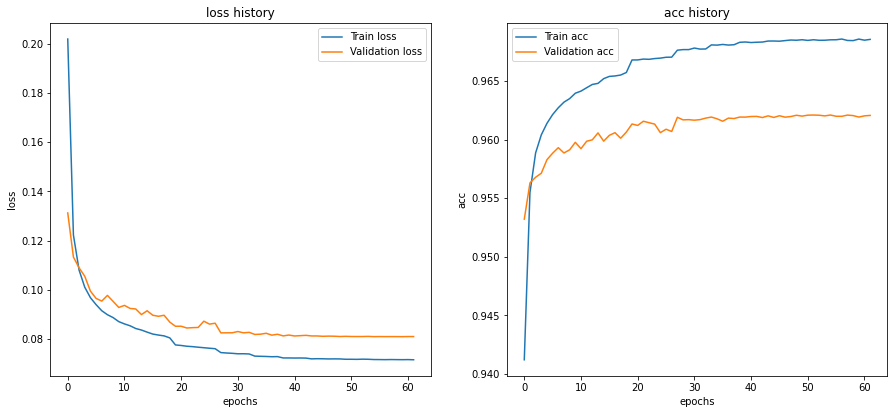

Best training accuracy: 0.96858
Best validation accuracy: 0.96210
****************************************
Fold 9 || Training
****************************************
Epoch 1/150
2191/2191 [==============================] - 38s 15ms/step - loss: 0.2064 - acc: 0.9408 - val_loss: 0.1289 - val_acc: 0.9550 - lr: 0.0010
Epoch 2/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.1235 - acc: 0.9550 - val_loss: 0.1139 - val_acc: 0.9562 - lr: 0.0010
Epoch 3/150
2191/2191 [==============================] - 28s 13ms/step - loss: 0.1087 - acc: 0.9584 - val_loss: 0.1114 - val_acc: 0.9562 - lr: 0.0010
Epoch 4/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.1013 - acc: 0.9603 - val_loss: 0.1009 - val_acc: 0.9586 - lr: 0.0010
Epoch 5/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.0965 - acc: 0.9615 - val_loss: 0.0995 - val_acc: 0.9586 - lr: 0.0010
Epoch 6/150
2191/2191 [==============================] - 29s 13ms/step - loss: 0.09

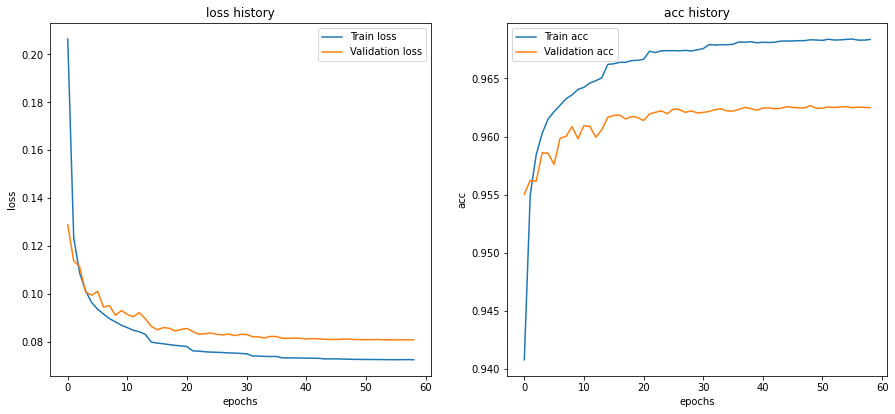

Best training accuracy: 0.96839
Best validation accuracy: 0.96266
****************************************
Fold 10 || Training
****************************************
Epoch 1/150
2191/2191 [==============================] - 40s 16ms/step - loss: 0.2045 - acc: 0.9407 - val_loss: 0.1304 - val_acc: 0.9544 - lr: 0.0010
Epoch 2/150
2191/2191 [==============================] - 30s 14ms/step - loss: 0.1231 - acc: 0.9551 - val_loss: 0.1158 - val_acc: 0.9554 - lr: 0.0010
Epoch 3/150
2191/2191 [==============================] - 30s 14ms/step - loss: 0.1085 - acc: 0.9585 - val_loss: 0.1059 - val_acc: 0.9574 - lr: 0.0010
Epoch 4/150
2191/2191 [==============================] - 30s 14ms/step - loss: 0.1012 - acc: 0.9603 - val_loss: 0.1028 - val_acc: 0.9579 - lr: 0.0010
Epoch 5/150
2191/2191 [==============================] - 30s 14ms/step - loss: 0.0966 - acc: 0.9615 - val_loss: 0.1012 - val_acc: 0.9577 - lr: 0.0010
Epoch 6/150
2191/2191 [==============================] - 30s 13ms/step - loss: 0.0

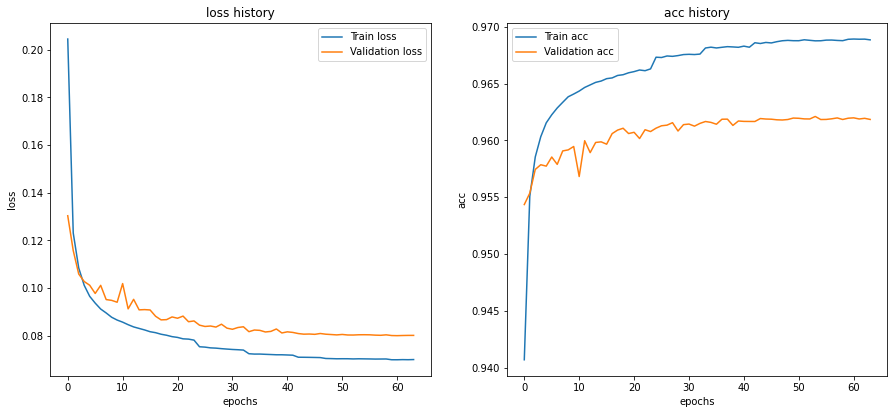

Best training accuracy: 0.96891
Best validation accuracy: 0.96210


In [ ]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 42)

predictions = np.zeros((len(Xt), len(encoder.classes_)))
scores = list()

for fold, (idx_train, idx_valid) in enumerate(cv.split(X, y)):
    
    idx_valid = idx_valid[idx_valid<len(X)]
    X_train, y_train = X[idx_train, :], target[idx_train]
    X_valid, y_valid = X[idx_valid, :], target[idx_valid]
    
    model = get_model(**dnn_params)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)    

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['acc'])

    print('**'*20)
    print(f"Fold {fold+1} || Training")
    print('**'*20)

    history = model.fit(
        X_train, y_train,
        validation_data = (X_valid, y_valid),
        batch_size = 2048,
        epochs = 150,
        verbose = 1,
        shuffle = True,
        callbacks = [
            early_stopping,
            reduce_lr])
    
    plot_keras_history(history, ['loss', 'acc'])
    
    print(f"Best training accuracy: {np.max(history.history['acc']):0.5f}")
    print(f"Best validation accuracy: {np.max(history.history['val_acc']):0.5f}")
    scores.append(np.max(history.history['val_acc']))

    predictions += model.predict(Xt, batch_size=2048)

## **7. Submission**

In [ ]:
submission.Cover_Type = encoder.inverse_transform(np.argmax(predictions, axis=1))
submission.to_csv(PATH + "submission.csv", header = True, index = False)